## Model description

This is the simplest model that I have made that is even somewhat accurate, at least when the conditions stay essentially constant.

1. There is an initial number, `N_0`, of new infections on the 0th day.
2. Number of new infections grow exponentially, with some constant exponential coefficient, `coef`.
3. A fraction (IFR, infection fatality rate) of new infections are expected to turn into deaths.
4. Deaths occur after an incubation period then a delay time from illness onset to death. These periods have predefined distributions, and the number of expected deaths on a given date is a convolution of the new infection over time with these 2 distributions.
5. Given the number of expected deaths on each day, the number of deaths is modeled as a Poisson process, and fit to the data.

In [48]:
from collections import defaultdict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pymc3 as pm

import covid_19.covid_func as cf

Data source for Chicago:

https://www.chicago.gov/city/en/sites/covid-19/home/latest-data.html

Pickle file is created in `create_data_pickles.ipynb` notebook.

Note that these numbers for Chicago do get updated even more than a week after the fact. It appears that they are trying to record accurate dates for these deaths, rather than simply keeping track of when they were reported/announced. This is not always the case for other agencies.

In [49]:
death_df = pd.read_pickle('../data/chi_deaths.pickle')

In [50]:
death_df.iloc[-10:]

,deaths
2020-04-06,18
2020-04-07,22
2020-04-08,33
2020-04-09,20
2020-04-10,26
2020-04-11,27
2020-04-12,29
2020-04-13,24
2020-04-14,20
2020-04-15,17


In [51]:
# Drop the last 7 days, to reduce the effects of incomplete data
death_df = death_df.iloc[:-7]

In [52]:
num_days = len(death_df)

In [53]:
death_list = list(death_df['deaths'])

#### Do a convolution

Incubation period from https://www.mdpi.com/2077-0383/9/2/538:

Lognormal distribution with mean 5.6 days, SD 2.8 days.

In [54]:
# Use lognorm_pdf function defined in covid_func.py
mean_i = 5.6
sd_i = 2.8

incubation_pdf = cf.lognorm_pdf(mean_i, sd_i)

In [55]:
incubation_array = np.array([incubation_pdf(x) for x in range(num_days)])

Onset-to-death delay from https://www.sciencedirect.com/science/article/pii/S1473309920302437

Gamma function with mean 17.8 days, coefficient of variation 0.45.

In [56]:
# Use gamma_pdf function defined in covid_func.py
mean_d = 17.8
cov_d = 0.45
sd_d = mean_d * cov_d

delay_pdf = cf.gamma_pdf(mean_d, sd_d)

In [57]:
delay_array = np.array([delay_pdf(x) for x in range(num_days)])

Given an array of infections, create a transfer matrix that turns it in to an array of cases with symptoms. The function to do this is defined in `covid_func.py`.

This is not exactly correct, as it ignores asymptotic cases, but I will multiply the whole array by the infection fatality rate (IFR) so the final answer will be modeled correctly.

In [58]:
incubation_mat = cf.create_delay_matrix(incubation_array, num_days)

It looks like this.

In [59]:
incubation_mat[:5,:5]

array([[0.        , 0.00251436, 0.06388876, 0.15624861, 0.18851108],
       [0.        , 0.        , 0.00251436, 0.06388876, 0.15624861],
       [0.        , 0.        , 0.        , 0.00251436, 0.06388876],
       [0.        , 0.        , 0.        , 0.        , 0.00251436],
       [0.        , 0.        , 0.        , 0.        , 0.        ]])

Similarly

In [60]:
delay_mat = cf.create_delay_matrix(delay_array, num_days)

In [61]:
transfer_mat = np.matmul(incubation_mat, delay_mat)

#### Set up the model

In [62]:
with pm.Model() as model:
    # There is some initial number of cases
    # The prior is an exponential distribution with mean 1.
    N_0 = pm.Exponential('initial', lam=1)
    
    # Growth rate is assumed to be constant
    # The prior is a wide normal distribution
    coef = pm.Normal('growth_constant', mu=0.3, sd=1)
    
    # Cases grow Exponentially
    N = N_0 * pm.math.exp(coef * (np.arange(num_days)))

    # IFR is calculated using 
    # https://www.sciencedirect.com/science/article/pii/S1473309920302437
    # and the population by age in the US
    IFR = 0.0095

    # Model proceeds as new infections -> expected new patients
    #                                  -> expected new deaths,
    # using the transfer matrices and the IFR
    exp_deaths = IFR * pm.math.matrix_dot(N, transfer_mat)

In [63]:
with model:
    # Given expected numbers of deaths,
    # fit to the data assuming this is a Poisson process for each day.
    D = pm.Poisson('deaths', mu=exp_deaths, observed=death_list)

#### Perform inference

In [64]:
with model:
    # Monte Carlo sampling to find the posterior distribution numerically
    step = pm.NUTS()
    trace = pm.sample(10000, tune=5000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [growth_constant, initial]
Sampling 2 chains, 0 divergences: 100%|██████████| 30000/30000 [01:33<00:00, 321.41draws/s]
The number of effective samples is smaller than 25% for some parameters.


I sometimes get divergences. This is not a good sign, and I welcome any ideas for avoiding them.

#### Plot results

Plot the results of the inference for the 2 undetermined parameters.

/Users/satoru/miniconda3/envs/pymc/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
/Users/satoru/miniconda3/envs/pymc/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
/Users/satoru/miniconda3/envs/pymc/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
/Users/satoru/miniconda3/envs/pymc/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(


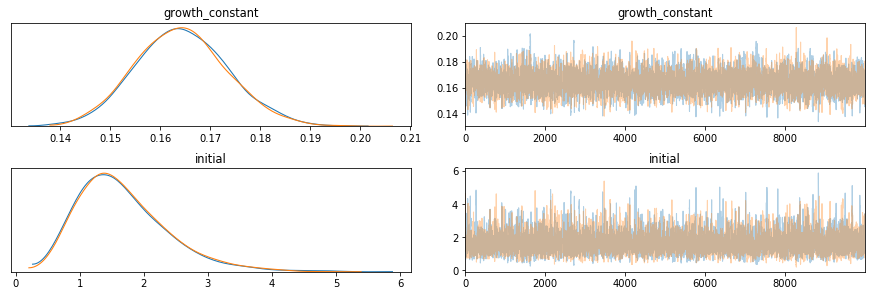

In [65]:
pm.traceplot(trace)
plt.show()

Create arrays of all the simulation results.

In [66]:
initial_array = np.array(trace['initial'])
growth_array = np.array(trace['growth_constant'])
doubling_array = np.log(2) / growth_array

Plot the histogram of doubling times.

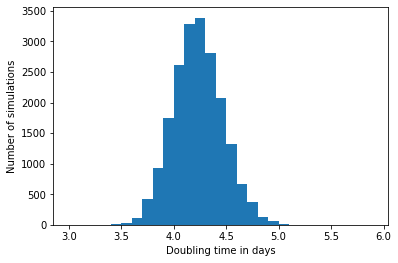

In [67]:
plt.hist(doubling_array, bins=np.arange(3., 6., 0.1))
plt.xlabel('Doubling time in days')
plt.ylabel('Number of simulations')
plt.show()

Calculate the predicted number of infections for all dates, for each simulation.

In [68]:
# This is the set of predictions for all simulations for each day
N_matrix = cf.batch_predict_N_exponential(initial_array=initial_array,
                                          growth_array=growth_array,
                                          num_days=num_days)

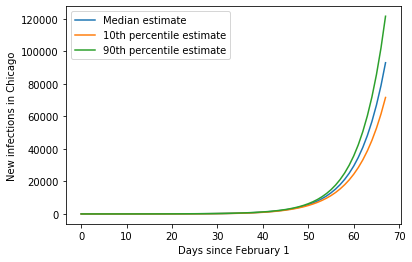

In [69]:
x = np.arange(num_days)
y_median = cf.percentile_prediction(N_matrix, 50)
y_10 = cf.percentile_prediction(N_matrix, 10)
y_90 = cf.percentile_prediction(N_matrix, 90)
plt.plot(x, y_median, label='Median estimate')
plt.plot(x, y_10, label='10th percentile estimate')
plt.plot(x, y_90, label='90th percentile estimate')
plt.xlabel('Days since February 1')
plt.ylabel('New infections in Chicago')
plt.legend()
plt.show()

This is an unrealistic model, because it assumes that the growth keeps going forever. Below, we will see how bad this is.

Calculate the expected number of deaths, and compare the predictions with actual numbers.

In [70]:
deaths_matrix = cf.batch_predict_deaths_from_infections(N_matrix,
                                                        incubation_pdf,
                                                        delay_pdf)

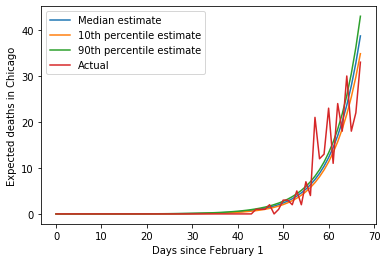

In [71]:
x = np.arange(num_days)
deaths_median = cf.percentile_prediction(deaths_matrix, 50)
deaths_10 = cf.percentile_prediction(deaths_matrix, 10)
deaths_90 = cf.percentile_prediction(deaths_matrix, 90)
plt.plot(x, deaths_median, label='Median estimate')
plt.plot(x, deaths_10, label='10th percentile estimate')
plt.plot(x, deaths_90, label='90th percentile estimate')
plt.plot(x, death_list, label='Actual')
plt.xlabel('Days since February 1')
plt.ylabel('Expected deaths in Chicago')
plt.legend()
plt.show()

This is not a terrible fit, but the last segment shows signs that the growth rate is now sub-exponential, making this a bad model.